In [5]:
#AIS_DDagnet_new
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data paths
train_dir = r'I:\csrc16\second\Deeplearning\png_441_images\fusion\CLAHE_aniso\train'
val_dir = r'I:\csrc16\second\Deeplearning\png_441_images\fusion\CLAHE_aniso\test'

# Define image size and batch size
img_width, img_height = 224, 224
batch_size = 16

# Define data generators with data augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

#new

def create_AISNet(input_shape, num_heads=8, key_dim=64):
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Convolutional layers
    conv1 = layers.Conv2D(6, (5,5), activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D((2,2))(conv1)
    conv2 = layers.Conv2D(16, (5,5), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D((2,2))(conv2)
    conv3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(pool2)
    avgpool1 = layers.AveragePooling2D((2, 2))(conv3)
    norm1 = layers.BatchNormalization()(avgpool1)
    pool3 = layers.MaxPooling2D((2,2))(conv3)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    pool4 = layers.MaxPooling2D((2,2))(conv4)
    conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool4)
    avgpool2 = layers.AveragePooling2D((2, 2))(conv5)
    norm2 = layers.BatchNormalization()(avgpool2)

    # Generate query, key, and value tensors
    query = layers.Conv2D(key_dim, (3, 3), activation='relu')(conv5)
    key = layers.Conv2D(key_dim, (3, 3), activation='relu')(conv5)
    value = layers.Conv2D(key_dim, (3, 3), activation='relu')(conv5)

    # Multi-head attention
    multi_head_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(query, key, value)

    # Flatten and dense layers for multi-head attention output
    flat_multi_head_att = layers.Flatten()(multi_head_att)
    dense_multi_head_att = layers.Dense(128, activation='relu')(flat_multi_head_att)
    drop_multi_head_att = layers.Dropout(0.5)(dense_multi_head_att)

    # Flatten and dense layers for norm1
    flat2_norm1 = layers.Flatten()(norm1)
    dense_norm1 = layers.Dense(128, activation='relu')(flat2_norm1)
    drop_norm1 = layers.Dropout(0.5)(dense_norm1)
    #dense2_norm1 = layers.Dense(64, activation='relu')(drop_norm1)
    #drop2_norm1 = layers.Dropout(0.5)(dense2_norm1)


    # Flatten and dense layers for norm2
    flat_norm2 = layers.Flatten()(norm2)
    dense_norm2 = layers.Dense(128, activation='relu')(flat_norm2)
    drop_norm2 = layers.Dropout(0.5)(dense_norm2)
    #dense2_norm2 = layers.Dense(64, activation='relu')(drop_norm2)
    #drop2_norm2 = layers.Dropout(0.5)(dense2_norm2)


    # Concatenate all features
    concatenated_features = layers.concatenate([drop_multi_head_att, drop_norm1, drop_norm2])

    # Output layer
    output = layers.Dense(2, activation='softmax')(concatenated_features)

    # Define model
    model = models.Model(inputs=inputs, outputs=output)
    return model
input_shape = (224, 224, 3)
num_classes = 3  # Replace with the actual number of classes in your problem
model_mhn = create_AISNet(input_shape)
model_mhn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Found 307 images belonging to 2 classes.
Found 133 images belonging to 2 classes.


In [6]:
history = model_mhn.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator
  )

Epoch 1/100
20/20 [==============================] - 30s 1s/step - loss: 1.7224 - accuracy: 0.5244 - val_loss: 0.6840 - val_accuracy: 0.5789
Epoch 2/100
20/20 [==============================] - 13s 626ms/step - loss: 0.6826 - accuracy: 0.6287 - val_loss: 0.6849 - val_accuracy: 0.5789
Epoch 3/100
20/20 [==============================] - 12s 602ms/step - loss: 0.7067 - accuracy: 0.5831 - val_loss: 0.6838 - val_accuracy: 0.5789
Epoch 4/100
20/20 [==============================] - 12s 605ms/step - loss: 0.6398 - accuracy: 0.6547 - val_loss: 0.6898 - val_accuracy: 0.5789
Epoch 5/100
20/20 [==============================] - 13s 613ms/step - loss: 0.6185 - accuracy: 0.6938 - val_loss: 0.6766 - val_accuracy: 0.5789
Epoch 6/100
20/20 [==============================] - 13s 613ms/step - loss: 0.6123 - accuracy: 0.6873 - val_loss: 0.6701 - val_accuracy: 0.5789
Epoch 7/100
20/20 [==============================] - 12s 605ms/step - loss: 0.5663 - accuracy: 0.6971 - val_loss: 0.6739 - val_accuracy: 0.

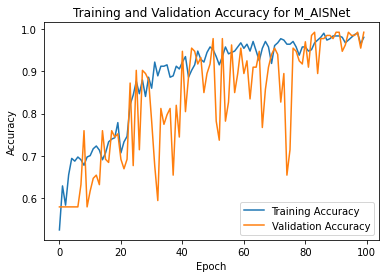

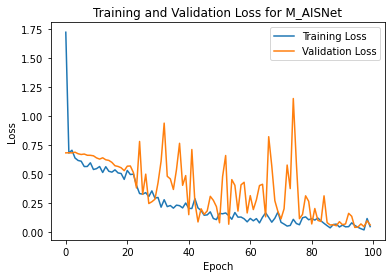

In [8]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for M_AISNet')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for M_AISNet')
plt.legend()
plt.show()


In [9]:
#acc-96.99
#AIS_DDagnet_new
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data paths
train_dir = r'I:\csrc16\second\Deeplearning\png_441_images\fusion\CLAHE_aniso\train'
val_dir = r'I:\csrc16\second\Deeplearning\png_441_images\fusion\CLAHE_aniso\test'

# Define image size and batch size
img_width, img_height = 224, 224
batch_size = 16

# Define data generators with data augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

def create_AISNet(input_shape, num_heads=8, key_dim=64):
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Convolutional layers
    conv1 = layers.Conv2D(6, (5,5), activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D((2,2))(conv1)
    conv2 = layers.Conv2D(16, (5,5), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D((2,2))(conv2)
    conv3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(pool2)
    avgpool1 = layers.AveragePooling2D((2, 2))(conv3)
    norm1 = layers.BatchNormalization()(avgpool1)
    pool3 = layers.MaxPooling2D((2,2))(conv3)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    pool4 = layers.MaxPooling2D((2,2))(conv4)
    conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool4)
    avgpool2 = layers.AveragePooling2D((2, 2))(conv5)
    norm2 = layers.BatchNormalization()(avgpool2)

    # Generate query, key, and value tensors
    query = layers.Conv2D(key_dim, (3, 3), activation='relu')(conv5)
    key = layers.Conv2D(key_dim, (3, 3), activation='relu')(conv5)
    value = layers.Conv2D(key_dim, (3, 3), activation='relu')(conv5)

    # Multi-head attention
    multi_head_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(query, key, value)

    # Flatten and dense layers for multi-head attention output
    flat_multi_head_att = layers.Flatten()(multi_head_att)
    dense_multi_head_att = layers.Dense(128, activation='relu')(flat_multi_head_att)
    drop_multi_head_att = layers.Dropout(0.5)(dense_multi_head_att)

    # Flatten and dense layers for norm1
    flat2_norm1 = layers.Flatten()(norm1)
    dense_norm1 = layers.Dense(128, activation='relu')(flat2_norm1)
    drop_norm1 = layers.Dropout(0.5)(dense_norm1)
    dense2_norm1 = layers.Dense(64, activation='relu')(drop_norm1)
    drop2_norm1 = layers.Dropout(0.5)(dense2_norm1)


    # Flatten and dense layers for norm2
    flat_norm2 = layers.Flatten()(norm2)
    dense_norm2 = layers.Dense(128, activation='relu')(flat_norm2)
    drop_norm2 = layers.Dropout(0.5)(dense_norm2)
    dense2_norm2 = layers.Dense(64, activation='relu')(drop_norm2)
    drop2_norm2 = layers.Dropout(0.5)(dense2_norm2)


    # Concatenate all features
    concatenated_features = layers.concatenate([drop_multi_head_att, drop2_norm1, drop2_norm2])

    # Output layer
    output = layers.Dense(2, activation='softmax')(concatenated_features)

    # Define model
    model = models.Model(inputs=inputs, outputs=output)
    return model
input_shape = (224, 224, 3)
num_classes = 3  # Replace with the actual number of classes in your problem
model_mh = create_AISNet(input_shape)
model_mh.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Found 307 images belonging to 2 classes.
Found 133 images belonging to 2 classes.


In [10]:
history = model_mh.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator
  )

Epoch 1/100
20/20 [==============================] - 17s 672ms/step - loss: 7.1267 - accuracy: 0.4788 - val_loss: 0.8827 - val_accuracy: 0.4211
Epoch 2/100
20/20 [==============================] - 12s 602ms/step - loss: 2.5117 - accuracy: 0.5212 - val_loss: 0.7186 - val_accuracy: 0.4211
Epoch 3/100
20/20 [==============================] - 13s 623ms/step - loss: 1.4546 - accuracy: 0.5375 - val_loss: 0.6994 - val_accuracy: 0.4211
Epoch 4/100
20/20 [==============================] - 12s 602ms/step - loss: 0.8081 - accuracy: 0.5505 - val_loss: 0.7339 - val_accuracy: 0.4211
Epoch 5/100
20/20 [==============================] - 12s 602ms/step - loss: 0.8031 - accuracy: 0.5537 - val_loss: 0.7073 - val_accuracy: 0.4211
Epoch 6/100
20/20 [==============================] - 13s 623ms/step - loss: 0.7155 - accuracy: 0.5472 - val_loss: 0.6920 - val_accuracy: 0.5564
Epoch 7/100
20/20 [==============================] - 13s 619ms/step - loss: 0.6798 - accuracy: 0.5863 - val_loss: 0.6828 - val_accuracy:

In [ ]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for M_AISNet2dense')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for M_AISNet2dense')
plt.legend()
plt.show()
